In [1]:
import string
import warnings
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Read data.
df = pd.read_csv("sentiment_analysis.csv")
print(df.head(5))
print(df.dtypes)



  airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...  
airline_sentiment    object
airline              object
text                 object
dtype: object


In [3]:
# Text Preprocessing:Text Analytics.

# Remove twitter handles.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# Function to remove punctuation marks.
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Function to remove stopwords.
def remove_stopwords(text):
    result = []
    for word in text.split():
        if word.lower() not in stopwords.words('english'):
            result.append(word.lower())
    return " ".join(result)

# Function to reduce words to their base form:Lemmatization.
def lemmatize_text(text):
    result =[]
    lemmatizer = WordNetLemmatizer()
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        result.append(lemmatizer.lemmatize(w))
    return ' '.join(result)

def remove_digits_special_characters(text):
    text = re.sub("[^a-zA-Z]"," ", text)
    return text



In [4]:
# Text preprocessing using various functions.
df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(remove_digits_special_characters)



In [5]:
print(df['text'].head(10))



0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
5    seriously would pay    flight seat didnt playi...
6    yes nearly every time fly vx   ear worm   won ...
7    really missed prime opportunity men without ha...
8                                       well didnt but
9                amazing arrived hour early youre good
Name: text, dtype: object


In [6]:
###############################################
# Exploratory Data analysis(EDA) :

# Check for null values:
print(df.isnull().sum())



airline_sentiment    0
airline              0
text                 0
dtype: int64


In [7]:
# Print unique categories of sentiments.
print(df["airline_sentiment"].unique())
# Print counts of each category.
print(df["airline_sentiment"].value_counts())



['neutral' 'positive' 'negative']
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [8]:
# Print unique airlines.
print(df["airline"].unique())
# Print counts of each airline.
print(df["airline"].value_counts())



['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


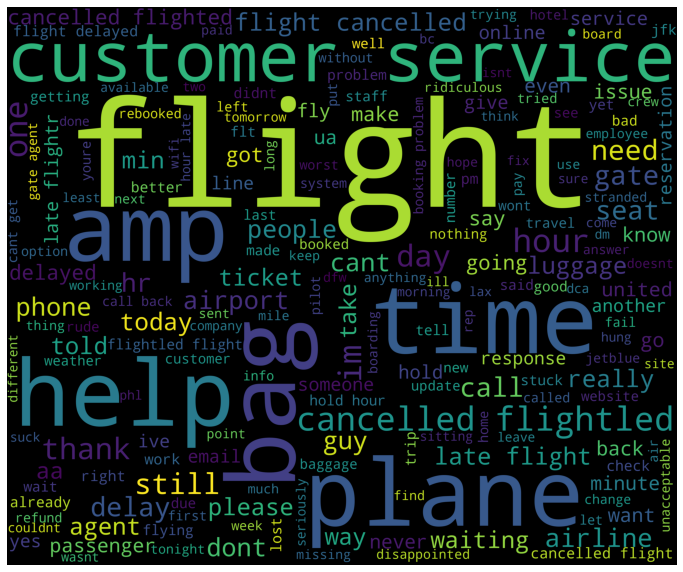

In [9]:
# Visualizations:

# WordCloud for negative words:
negative=df[df['airline_sentiment']=='negative']
words = ' '.join(negative['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("negative_words.png")
plt.show()

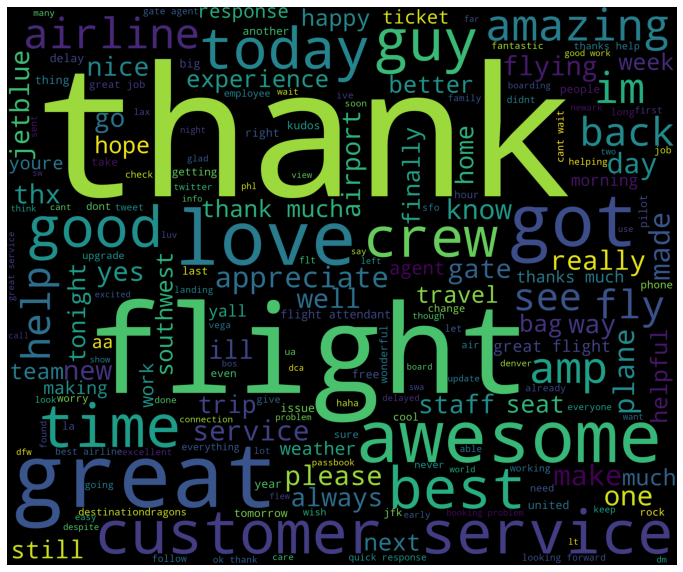

In [10]:
# WordCloud for positive words:
positive=df[df['airline_sentiment']=='positive']
words = ' '.join(positive['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("positive_words.png")
plt.show()



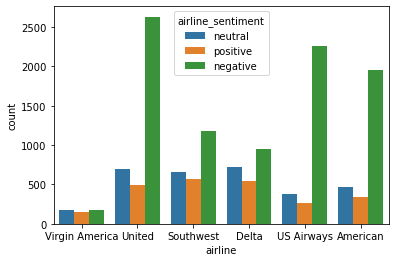

In [11]:
# Visualizing relationship between various sentiments and airlines:
sns.countplot(x='airline',hue='airline_sentiment',data = df)
plt.savefig("Airline_vs_Sentiment.png")
plt.show()



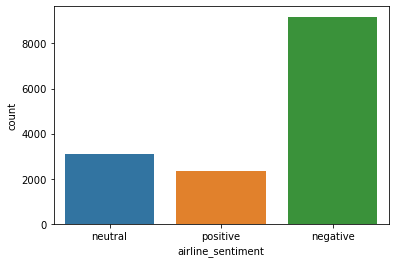

In [12]:
# Visualizing Counts of different airline sentiments.
sns.countplot(x='airline_sentiment',data=df)
plt.savefig("Sentiments.png")
plt.show()



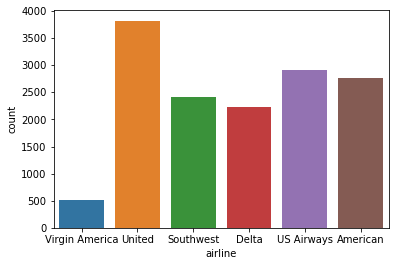

In [13]:
# Visualizing Counts of different airlines.
sns.countplot(x='airline',data=df)
plt.savefig("Airlines.png")
plt.show()



In [14]:
# Encoding categorical target variable.
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative':1,'neutral':0,'positive':2})



In [15]:
# Seperating X and Y.
X = df['text']
Y = df['airline_sentiment']

# Train and Test split.
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y,test_size=.20,random_state=0)

# Vectorization of words into features:
word_vectorizer = TfidfVectorizer(max_features=5000)
vector_X_train = word_vectorizer.fit_transform(X_train)
vector_X_test = word_vectorizer.transform(X_test)
vector_array_train = vector_X_train.toarray()
vector_array_test = vector_X_test.toarray()


In [16]:
# Modelling:

# Linear support vector classifier.
lsvc = LinearSVC(C=1,loss= 'hinge')
lsvc.fit(vector_array_train, y_train)
y_pred = lsvc.predict(vector_array_test)
print(f1_score(y_test,y_pred,average='micro')) # 0.7872


0.7872267759562842


In [17]:
# Logistic Regression.
lr = LogisticRegression()
lr.fit(vector_array_train, y_train)
y_pred = lr.predict(vector_array_test)
print(f1_score(y_test,y_pred,average='micro'))  # 0.7814



0.7814207650273223


In [18]:
# Random Forest Classifier.
rfc = RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(vector_array_train,y_train)
y_pred = rfc.predict(vector_array_test)
print(f1_score(y_test,y_pred,average='micro'))   # 0.7616



0.7616120218579235


In [19]:
# Bernoulli Naive Bayes.
bnb = BernoulliNB()
bnb.fit(vector_array_train,y_train)
y_pred = bnb.predict(vector_array_test)
print(f1_score(y_test,y_pred,average='micro'))  # 0.7790



0.7790300546448088


In [20]:
# Ridge Classifier.
ridge = RidgeClassifier(random_state=0)
ridge.fit(vector_array_train,y_train)
y_pred = ridge.predict(vector_array_test)
print(f1_score(y_test,y_pred,average='micro'))  # 0.7790



0.7790300546448088


In [21]:
# Topic Modelling: Understand Themes of customer feedback.
# Topic Modelling using Latent Dirichlet Allocation(LDA):
count_vect = CountVectorizer(max_df=0.8, min_df=2,stop_words='english')
doc_term_matrix = count_vect.fit_transform(X_train)

# Each of x documents is represented as y dimensional vector,which means that our vocabulary has y words.
LDA = LatentDirichletAllocation(n_components=5,random_state=0)
LDA.fit(doc_term_matrix)

# For each topic,each word of the document is assigned a weight.
# Higher weight means it is the top word of the topic.
# It is a multidimensional array.Each row represent the topic,each column represents the word in a document.
# Shape = [n_topics,n_words] or [n_components, n_features]

# Print top words for each topic.
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(index))
        # feature_names[i] is a word,topic[i] is the weight of the word for that topic.
        print([(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]])
        print("=" * 50)

print("\nTopics in LDA model: ")
tf_feature_names = count_vect.get_feature_names()
print_top_words(LDA, tf_feature_names, 10)




Topics in LDA model: 

Topic #0:
[('flight', 363.32766900119907), ('need', 329.70864609162766), ('seat', 317.7416847668351), ('help', 297.64586931489623), ('dont', 246.38691487806713), ('dm', 209.95313007420708), ('phone', 197.37638253543273), ('time', 190.5022514952133), ('ticket', 184.3797048017125), ('number', 173.38510325081162)]

Topic #1:
[('flight', 732.4987604852355), ('thank', 503.19268094918465), ('problem', 213.8337058886375), ('time', 134.70894100699354), ('trip', 120.01743132704557), ('booking', 117.19626166830257), ('people', 114.49231528895996), ('delay', 112.38876852285932), ('working', 99.01018095697344), ('say', 92.18680187484385)]

Topic #2:
[('flight', 1054.6223192756834), ('cancelled', 828.2658970778598), ('flightled', 402.19442394943934), ('bag', 392.21051312451874), ('hour', 326.1036125981256), ('hold', 307.70846584526515), ('help', 255.7464571590889), ('day', 184.20317248182803), ('amp', 183.23226809149193), ('flighted', 167.65825255379272)]

Topic #3:
[('fligh